In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/scikit-explain/tutorial_notebooks')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
import shap
import plotting_config
from skexplain.plot.base_plotting import PlotStructure
from skexplain.common.contrib_utils import get_indices_based_on_performance
import numpy as np
import pandas as pd
from bayeshist import bayesian_histogram
import matplotlib.pyplot as plt

from load_models_and_data import load_model_and_data
from probsr_config import FIGURE_MAPPINGS, UNITS
from display_names import to_readable_names, get_units
from load_explain_data import load_explain
#import similaritymeasures
from scipy.interpolate import interp1d
from top_features import top_features
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.metrics import mean_squared_error, r2_score
from scipy.ndimage import gaussian_filter

from scipy.stats import spearmanr, kendalltau

In [2]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]

    inds = np.digitize(feature_vals, bins=bins) - 1
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [3]:
from scipy.stats import spearmanr

def normalize(d):
    denom = (np.max(d) - np.min(d))
    if denom < 0.0000001:
        denom = 0.00001
    
    return (d-np.min(d)) / denom

def score(d1, d2):
    return abs(kendalltau(d1, d2)[0])
    
def rmse(d1, d2):
    return np.sqrt(mean_squared_error(d1, d2))
    
def measure_corr(ale, shap_vals, pd_ds, lime_vals, X_lime, ti_vals=None, X_ti=None, 
                 plot=False, features=None):
    
    if ti_vals is not None:
        name = 'Random Forest'
        labels = ['ale', 'pd', 'shap',   'lime',    'ti']
    else:
        labels = ['ale', 'pd', 'shap',    'lime']
        name = 'LogisticRegression'
    
    if features is None:
        features = ale.attrs['features used']
    
    n_methods = len(labels)
    n_features = len(features)
    
    vals = np.zeros((n_methods, n_features))
    r2s = np.zeros((n_methods, n_features))
    weights = np.zeros((n_features))
    
    for i, feature in enumerate(features):
        if feature in ['rural', 'urban']:
            continue
    
        ale_x = ale[f'{feature}__bin_values'].values
        ale_y =  np.mean(ale[f'{feature}__{name}__ale'].values, axis=0)
        
        pd_x = pd_ds[f'{feature}__bin_values'].values
        pd_y = np.mean(pd_ds[f'{feature}__{name}__pd'].values, axis=0)
        
        mean_shap = shap_to_curve(feature, shap_vals, X_shap, ale_x)
        mean_lime = shap_to_curve(feature, lime_vals, X_lime, ale_x)
        if ti_vals is not None:
            mean_ti = shap_to_curve(feature, ti_vals, X_ti, ale_x)
        
        data = X[feature].values.astype(float)
        bin_edges, beta_dist = bayesian_histogram(data, y)
        bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
        
        base_rate = beta_dist.median()
        centered_base_rate = base_rate-np.mean(base_rate)
        br_norm = normalize(centered_base_rate)
        
        ypreds = []
        if ti_vals is not None:
            ys     = [ale_y, pd_y, mean_shap, mean_lime, mean_ti]
            labels = ['ale', 'pd', 'shap',   'lime',    'ti']
        else:
            ys     = [ale_y, pd_y, mean_shap, mean_lime]
            labels = ['ale', 'pd', 'shap',    'lime']
        
        for j, (label, y_vals) in enumerate(zip(labels, ys)):
            if label == 'pd':
                func = interp1d(pd_x, y_vals, fill_value="extrapolate")
            elif label in ['shap', 'lime', 'ti']:
                try:
                    func = interp1d(ale_x, y_vals, fill_value="extrapolate")
                except ValueError:
                    func = interp1d(ale_x[:-1], y_vals, fill_value="extrapolate")
            else:
                func = interp1d(ale_x, y_vals, fill_value="extrapolate")
                    
            y_pred = func(bin_centers)
            ypreds.append(y_pred)

            vals[j,i] = score(y_pred, br_norm) 
            r2s[j,i] = rmse(centered_base_rate, y_pred)
            
        weights[i] = np.var(centered_base_rate)
        
        if plot:
            fig = plt.figure(dpi=150)
            # [gaussian_filter(centered_base_rate, 1.5)]
            for d, label in zip(ypreds, labels):
                #norm_d = d / (np.max(d) - np.min(d))
                #plt.plot(bin_centers, norm_d, label=label)
                plt.plot(bin_centers, d*100, label=label)
            plt.xlabel(f'{feature}')
            plt.ylabel(f'{feature}\nEffect/ConditionalEvent Rate (%)')
            plt.legend()
    
    ##vals[vals>2] = 0
    
    # Compute base rate-weighted avg correlation and R^2 score. 
    mean = [DescrStatsW(vals[i,:], weights=weights, ddof=1).mean for i in range(n_methods)]
    mean_r2 = [DescrStatsW(r2s[i,:], weights=weights, ddof=1).mean for i in range(n_methods)]

    df = pd.DataFrame(np.reshape(mean, (1, len(labels))), columns=labels)
    df_r2 = pd.DataFrame(np.reshape(mean_r2, (1, len(labels))), columns=labels)
    
    return df, df_r2

overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
overflow encountered in exp
overflow encountered in exp


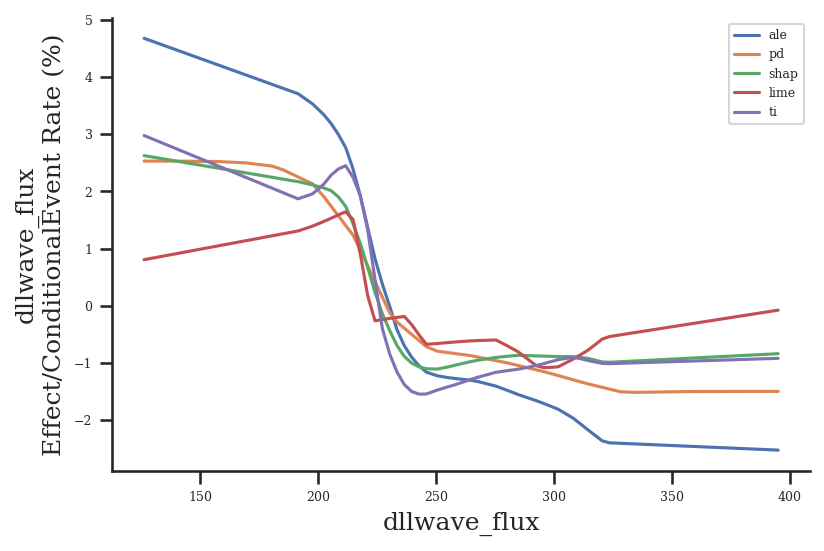

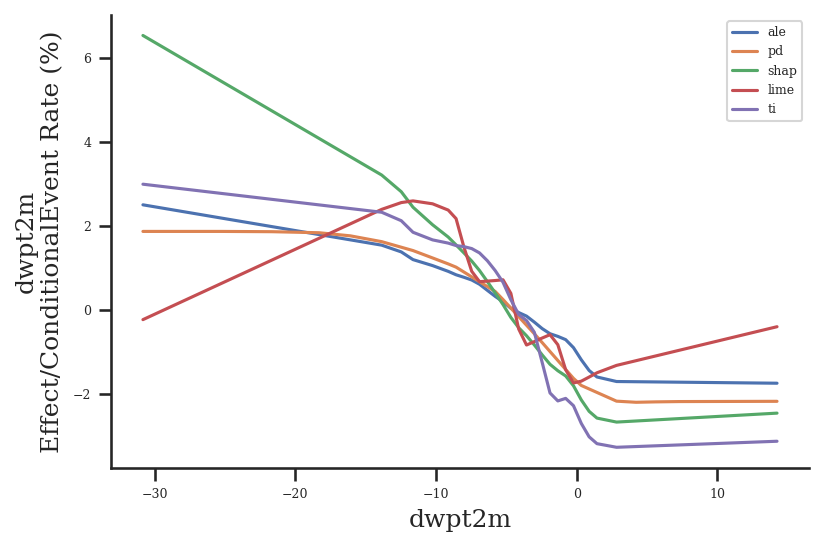

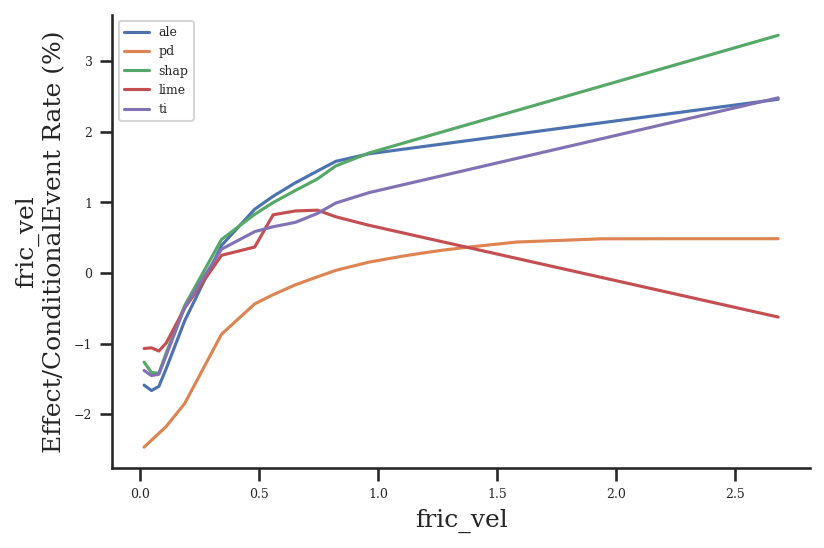

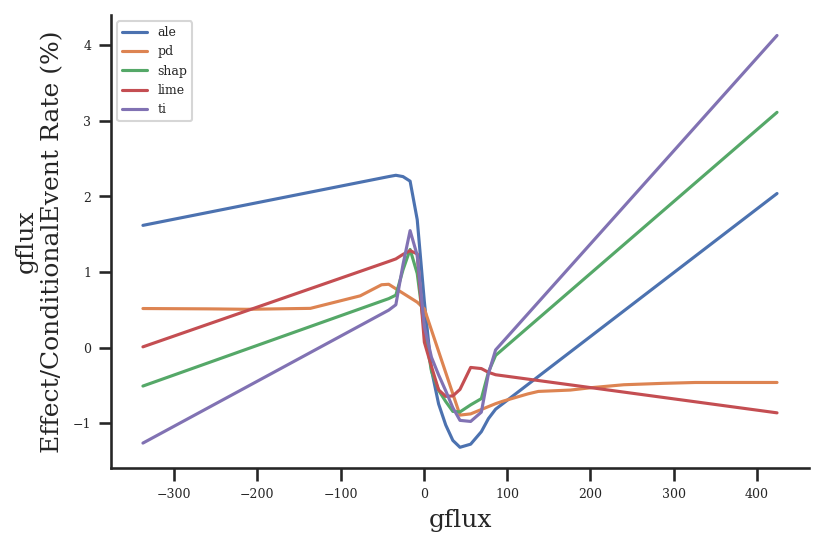

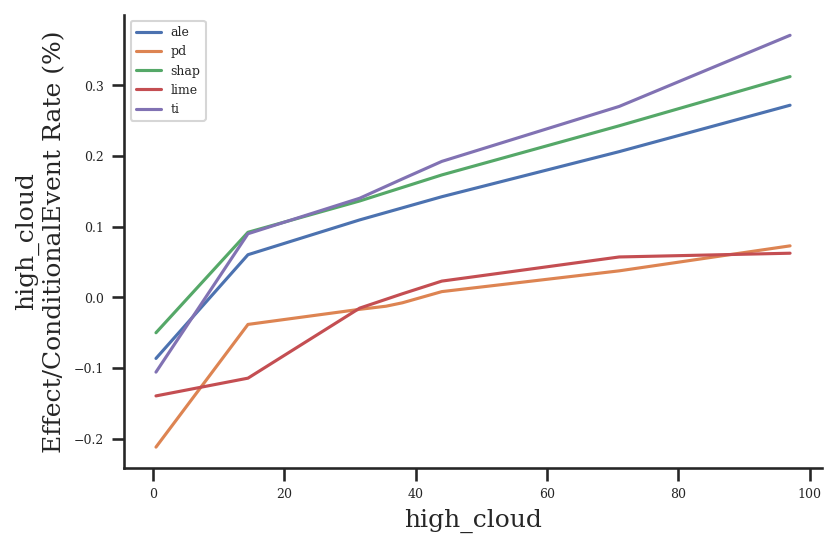

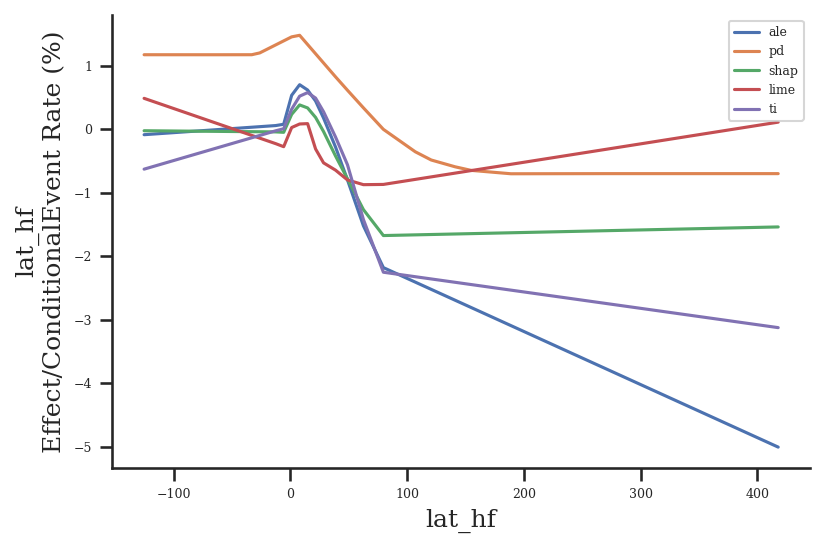

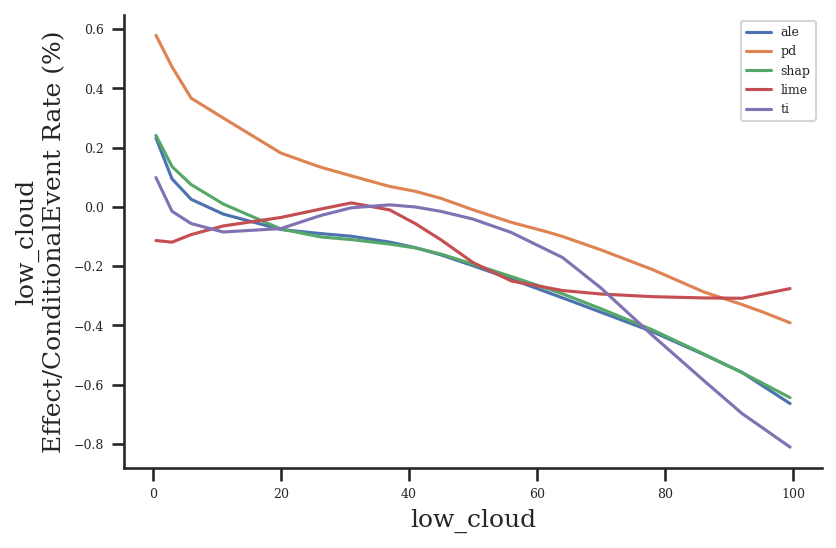

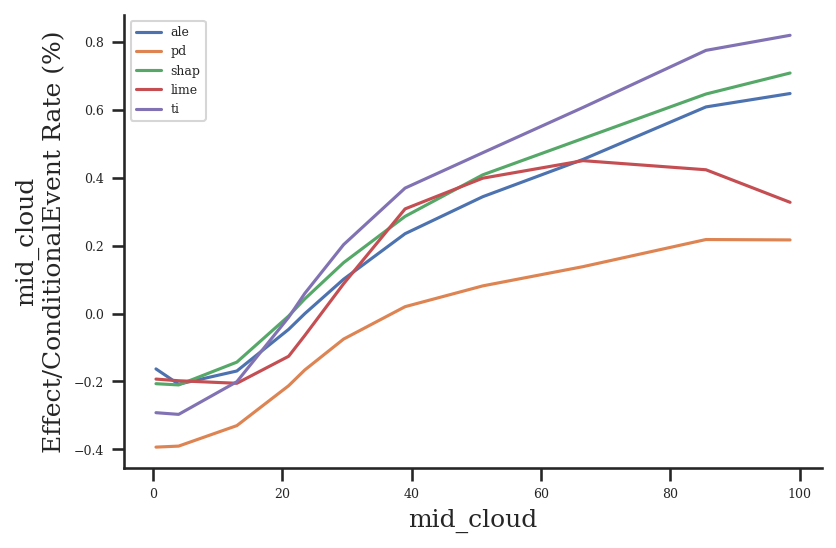

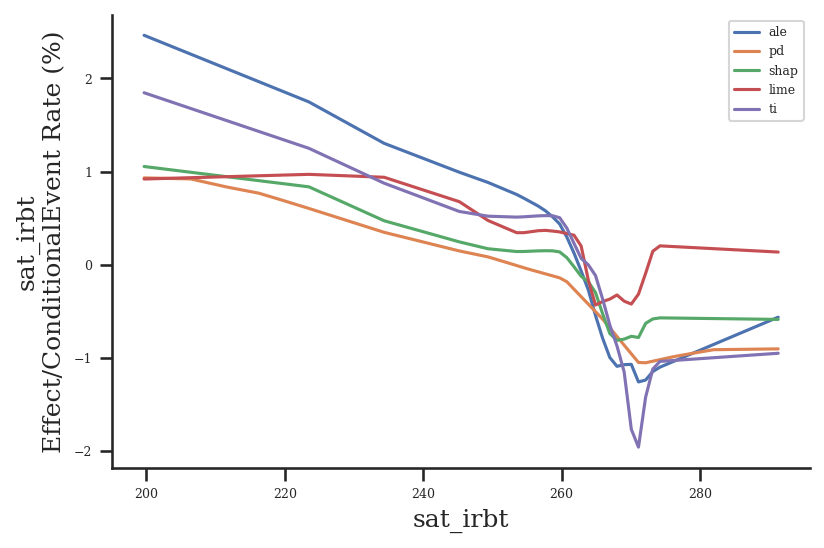

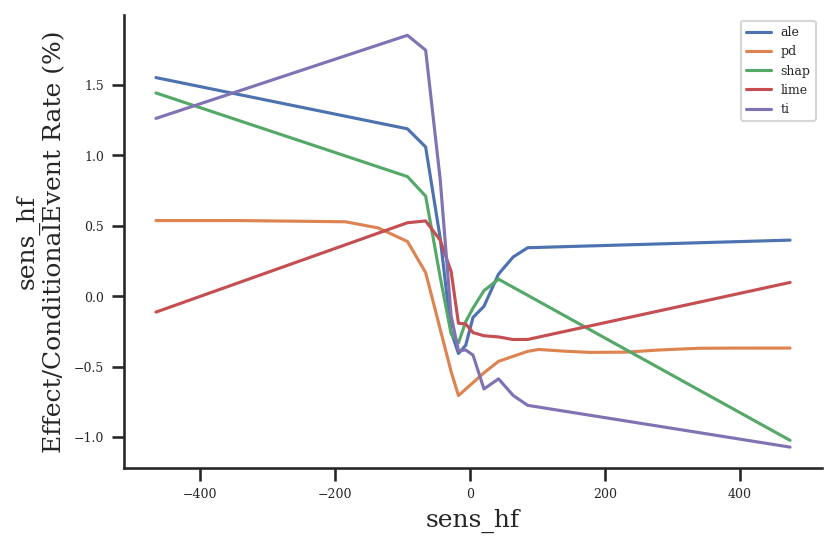

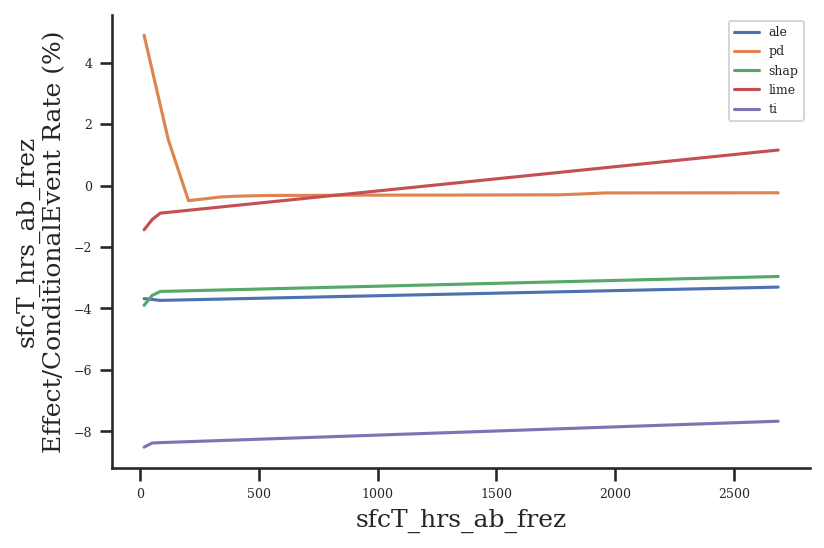

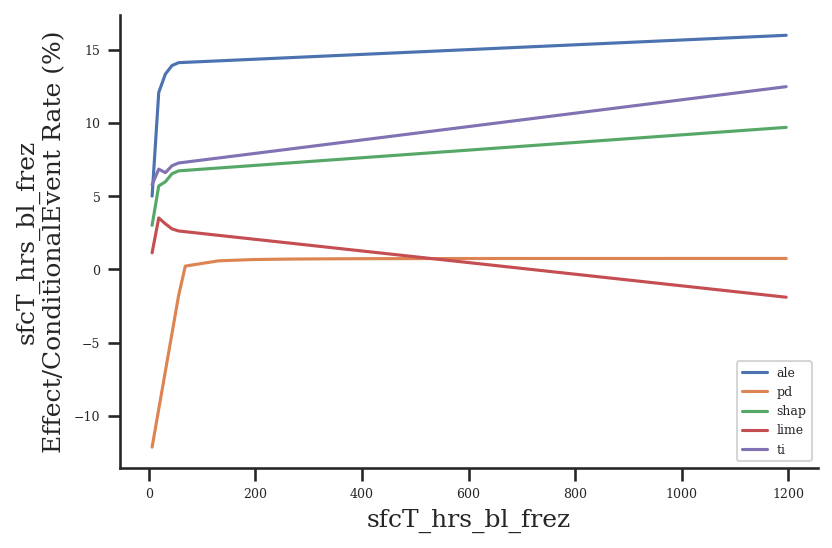

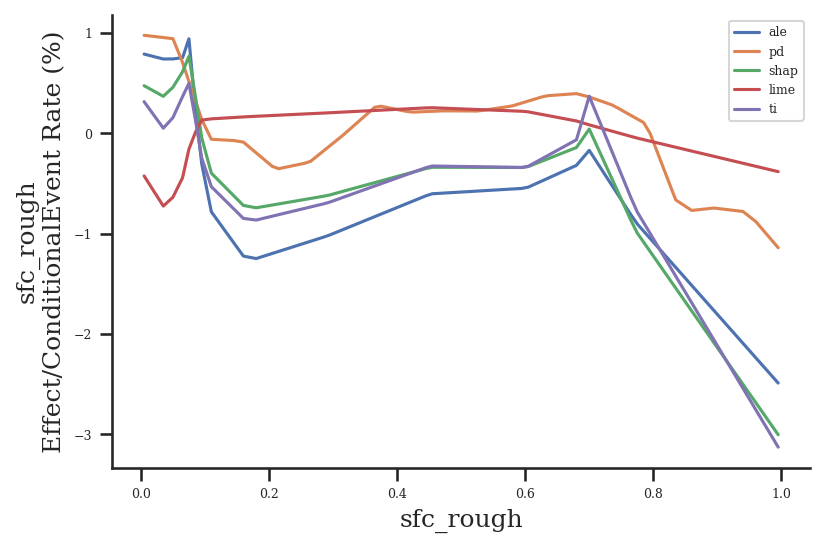

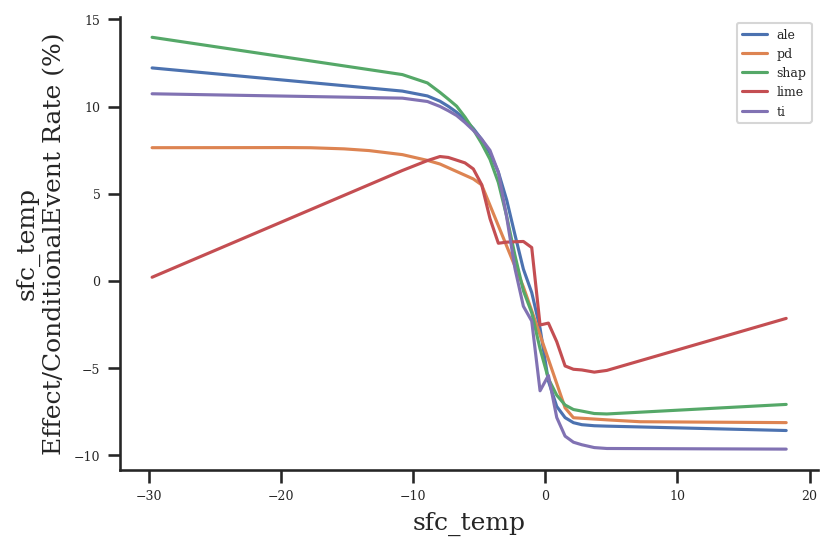

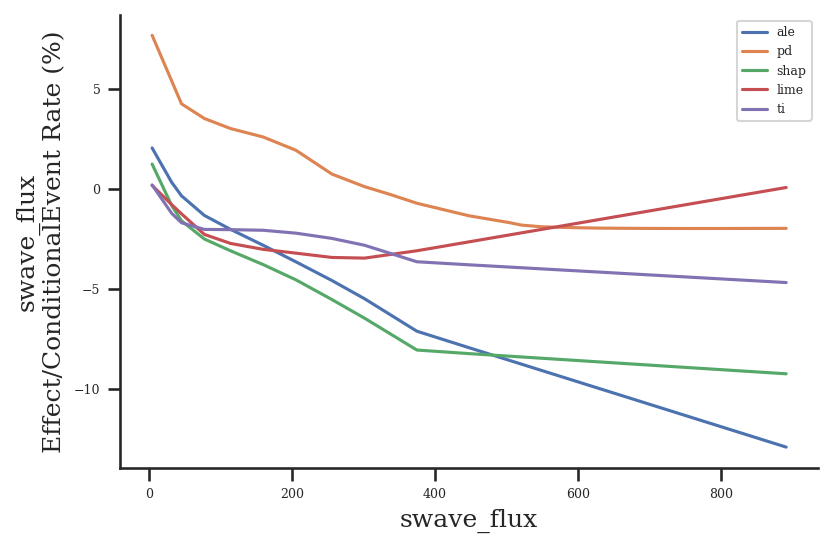

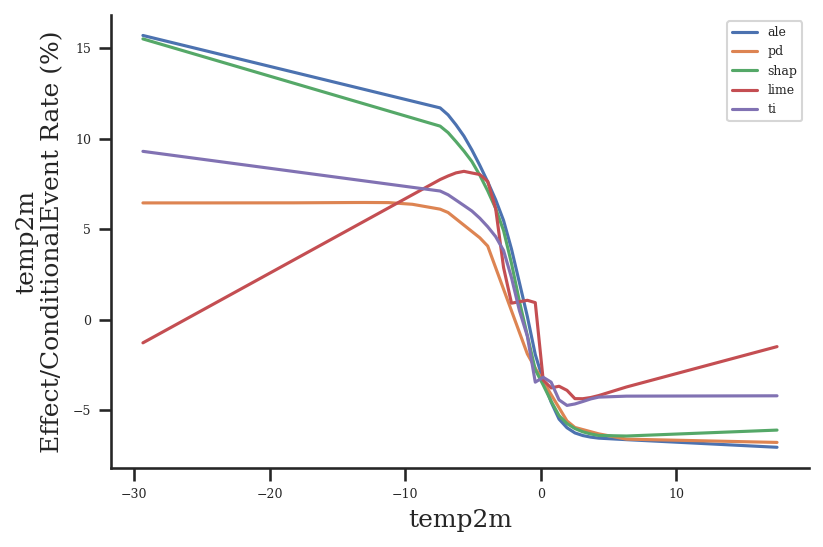

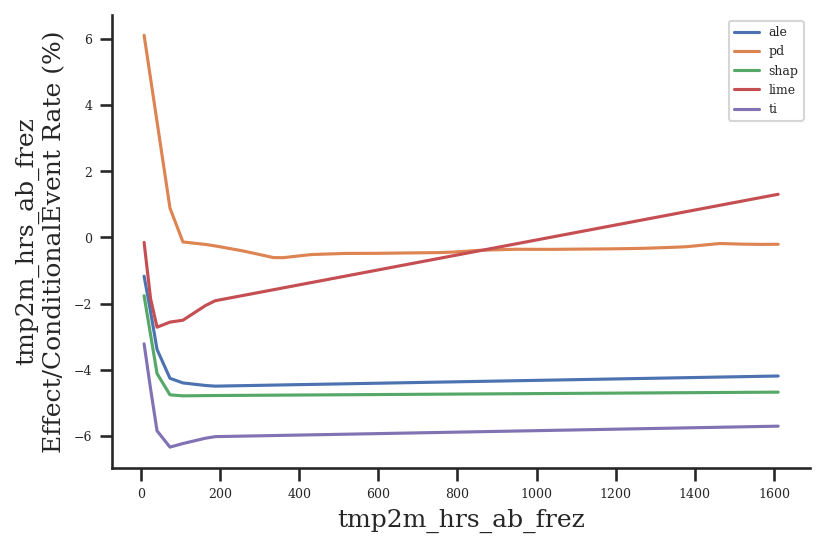

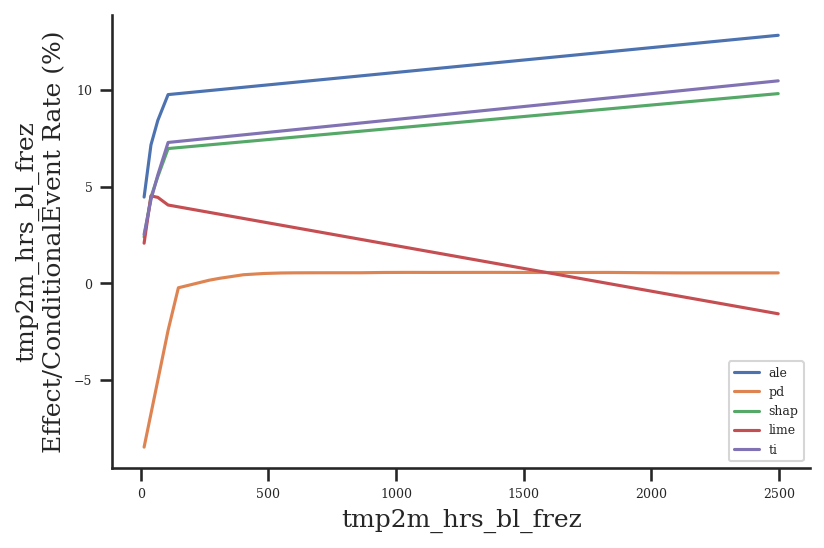

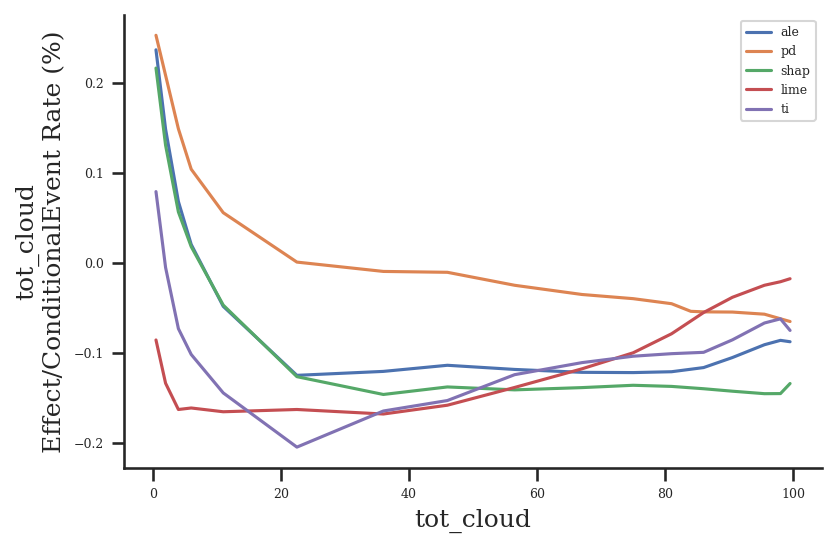

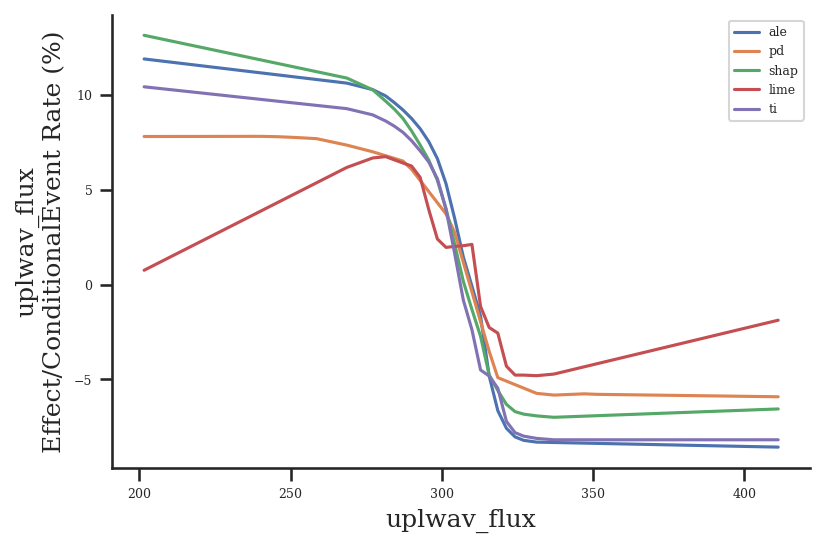

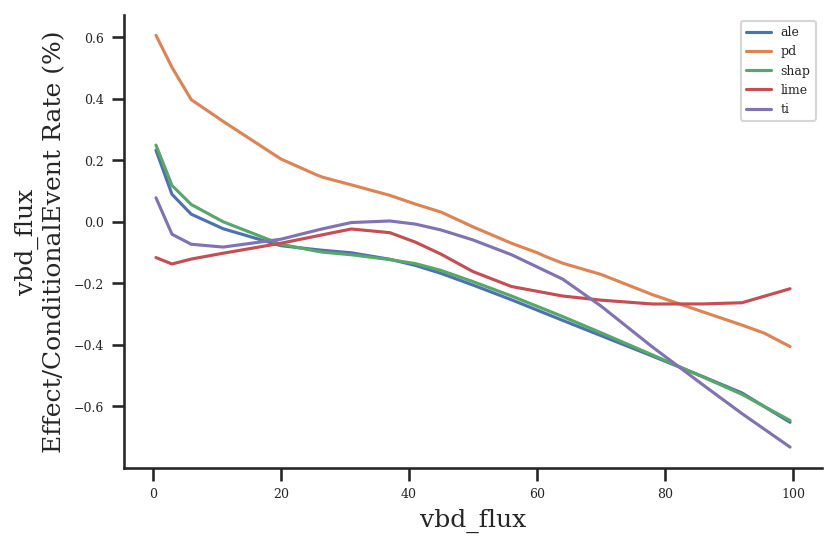

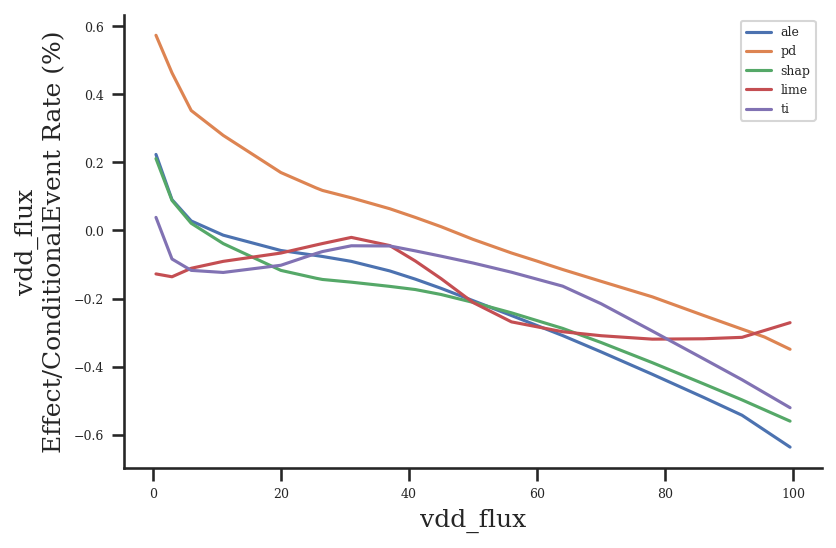

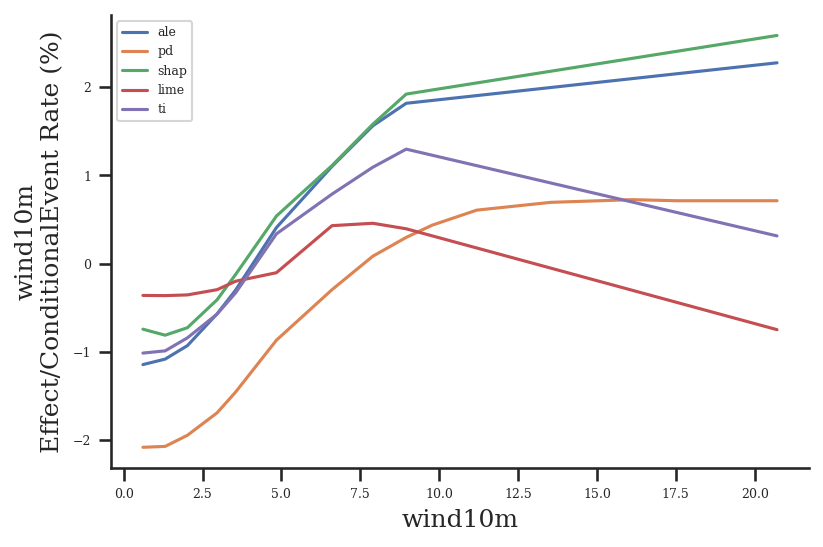

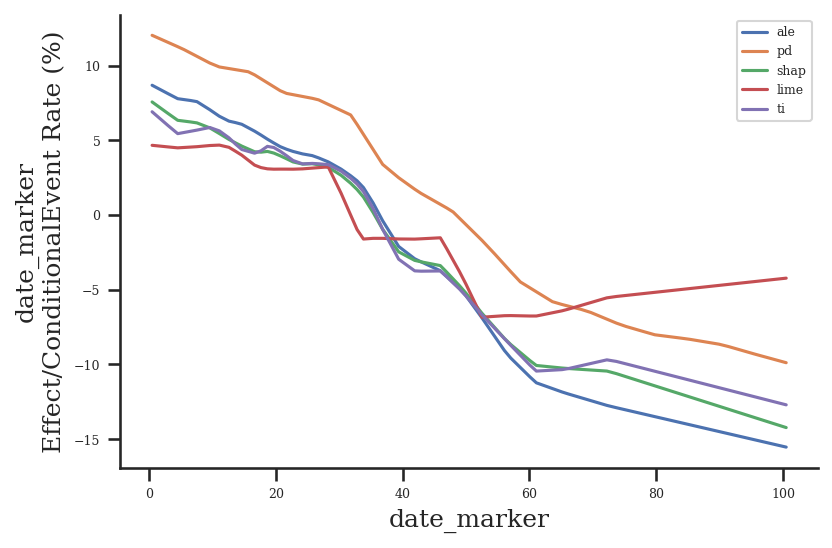

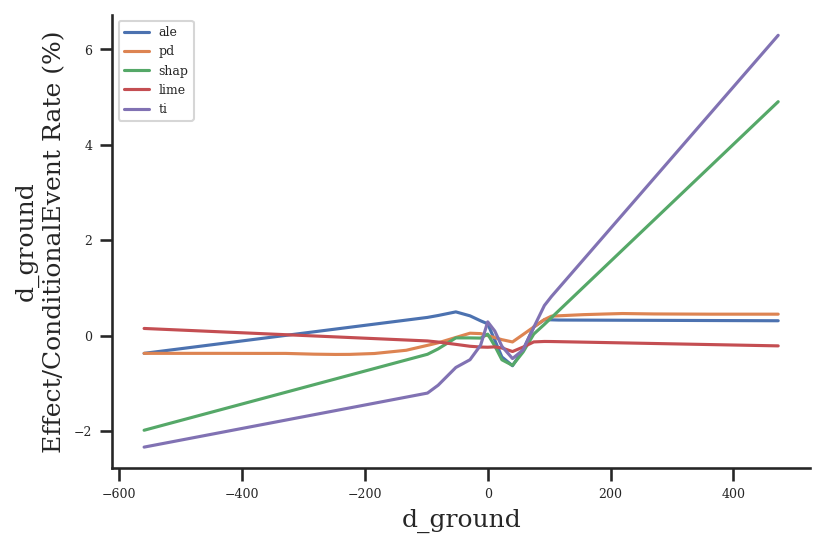

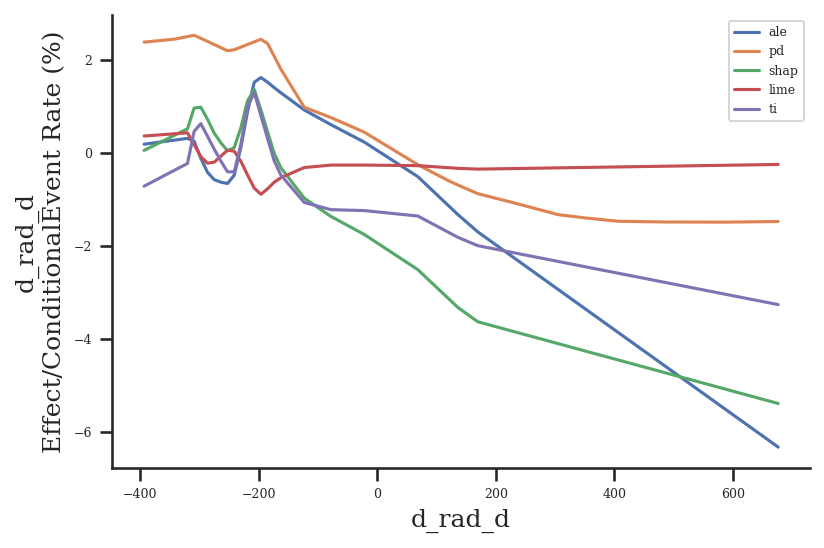

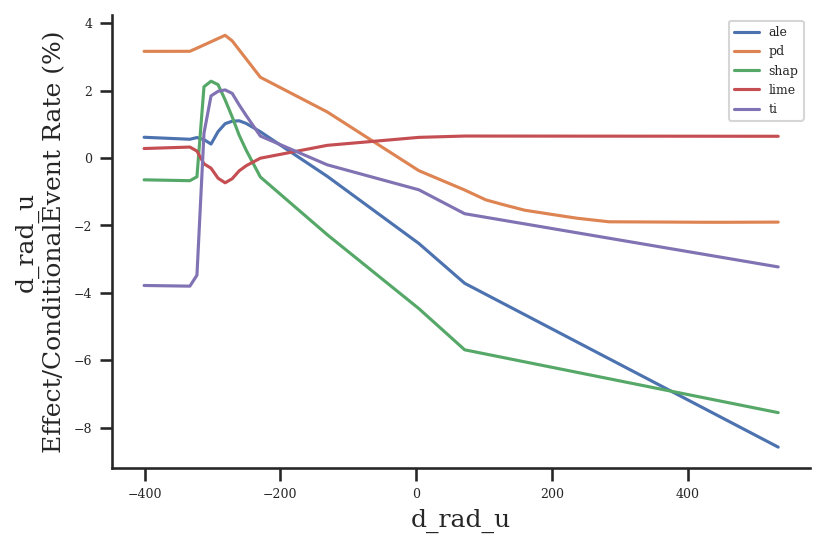

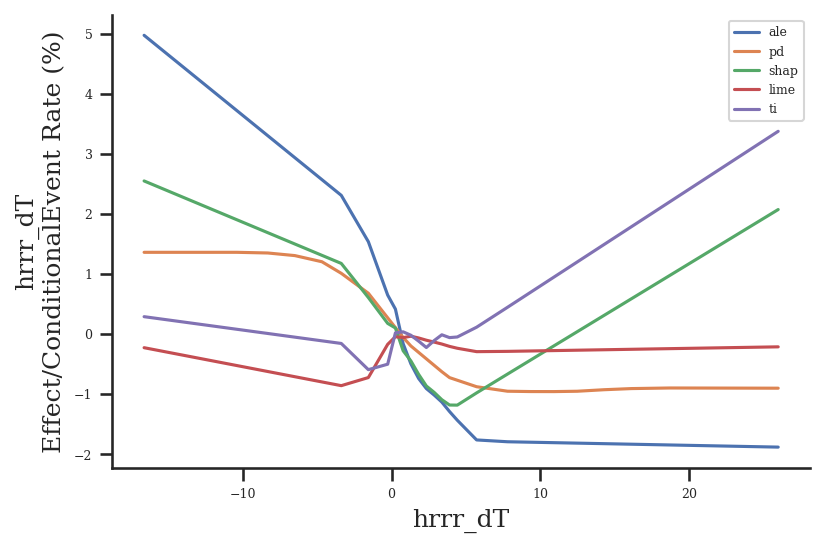

In [6]:
keys = ['ale',    'shap', 'pd', 'lime', 'ti']
columns = ['ALE', 'SHAP', 'PD', 'LIME', 'TI']

dfs = []
dfs_std = []
hazards = ['road_surface'] #['tornado', 'severe_hail', 'severe_wind', 'road_surface']

for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    ale, _, shap_vals, X_shap, pd_ds, lime_vals, X_lime, ti_vals, X_ti = load_explain(hazard,  return_pd=True)
    df, df_std = measure_corr(ale, shap_vals, pd_ds, lime_vals, X_lime, ti_vals, X_ti, plot=True)
    dfs.append(df)
    dfs_std.append(df_std)
    
df = pd.concat(dfs, axis=0)
df_std = pd.concat(dfs_std, axis=0)

## RMSD for all features

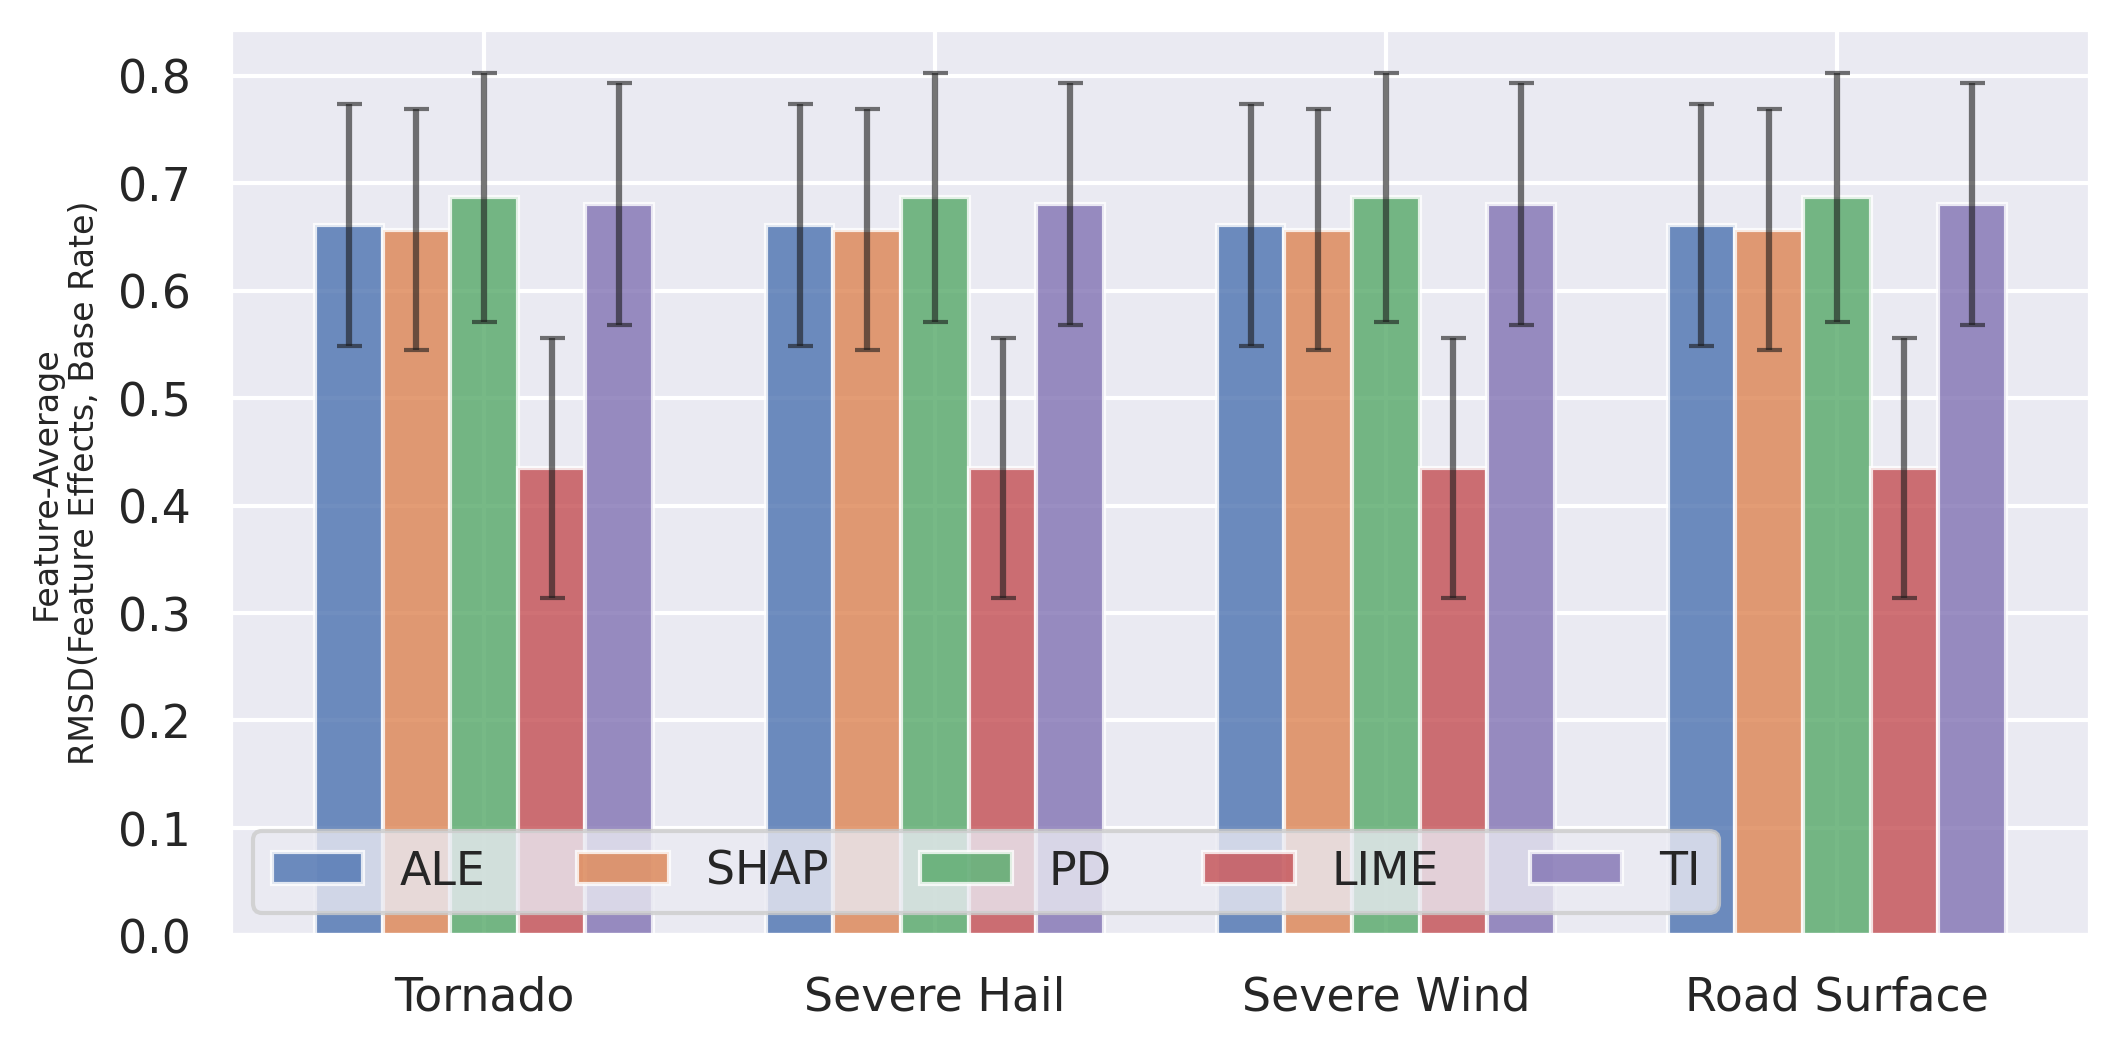

In [5]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(dpi=300, figsize=(8,4))
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

pos = (x-(2*width), x-width, x, x+width, x+(2*width))

ax.bar(pos[0], df_std['ale'], alpha=0.8, 
       width=width, label='ALE')#, yerr=df_std['ale']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[1] , df_std['shap'], alpha=0.8,
       width=width, label='SHAP')#, yerr=df_std['shap']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[2], df_std['pd'], alpha=0.8,
       width=width, label='PD')#, yerr=df_std['pd']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[3], df_std['lime'], alpha=0.8,
       width=width, label='LIME')#, yerr=df_std['lime']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[4], df_std['ti'], alpha=0.8,
       width=width, label='TI')#, yerr=df_std['ti']/2, capsize=3, error_kw={'alpha':0.6})

ax.set_ylabel('Feature-Average\nRMSD(Feature Effects, Centered Event Rate)', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend(ncol=5, loc='lower left')

## RMSD for top 10 features

Loading /work/mflora/ML_DATA/MODEL_SAVES/LogisticRegression_first_hour_severe_hail_under_standard_.pkl...
Loading data...


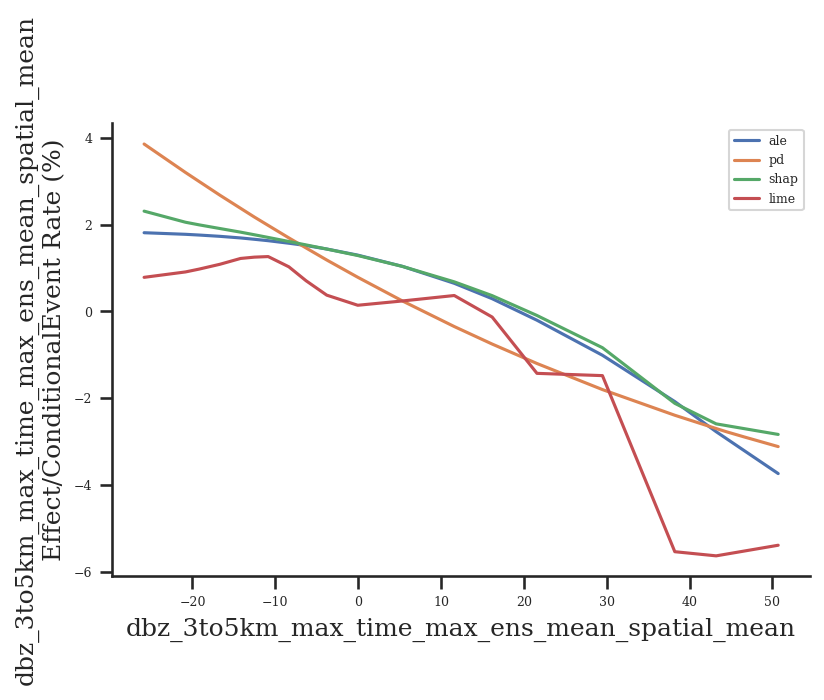

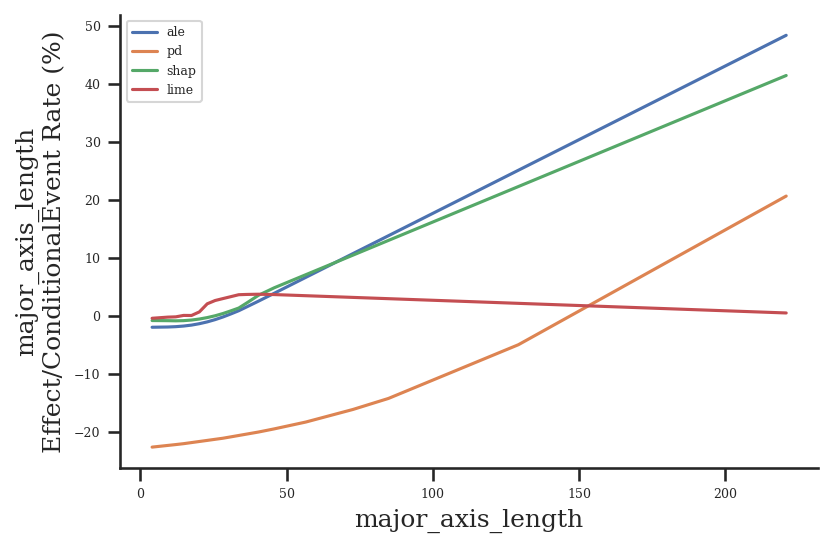

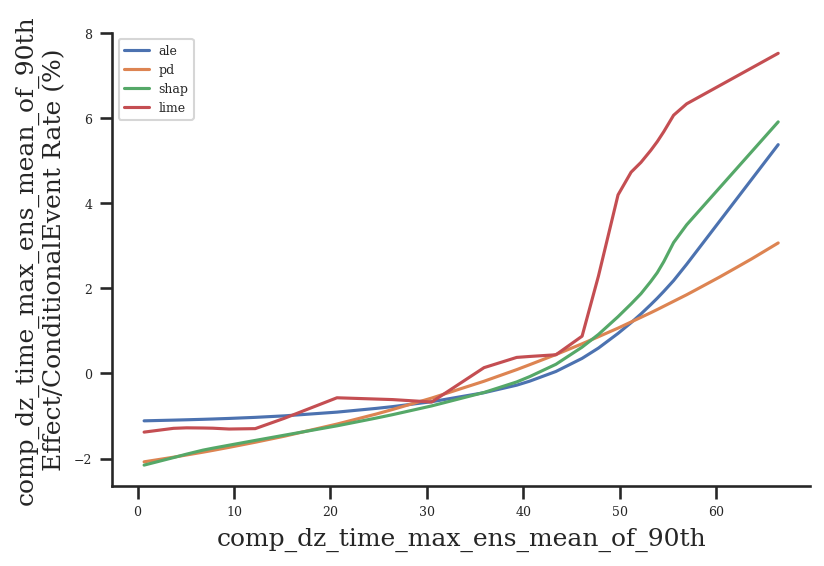

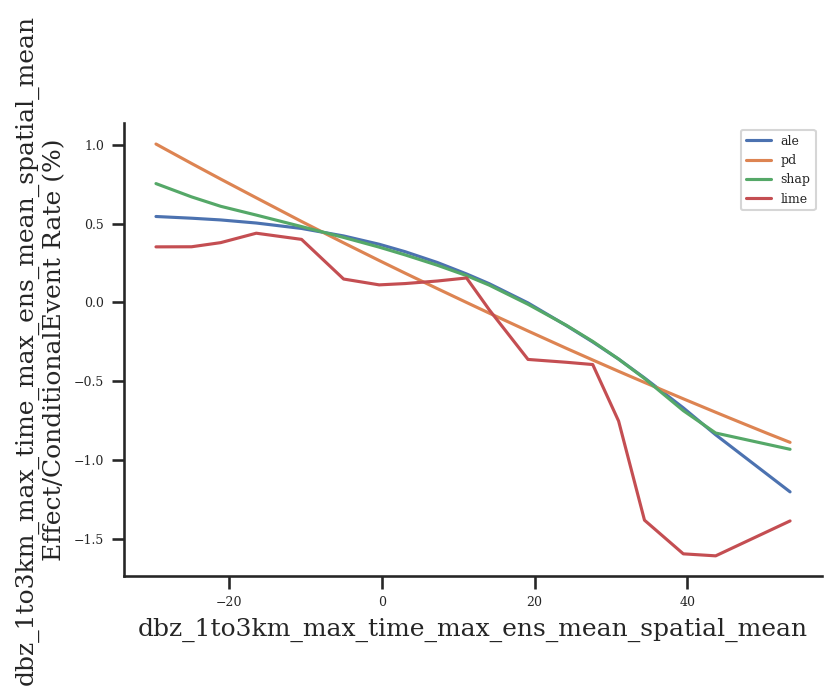

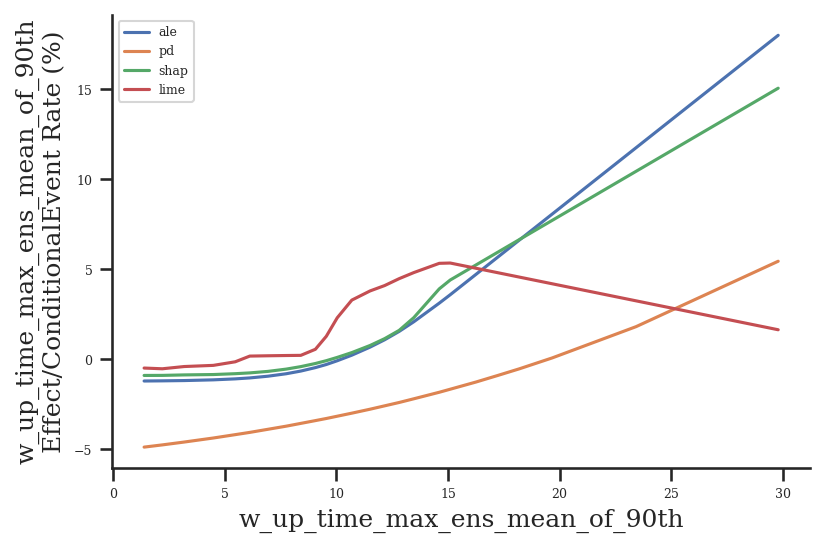

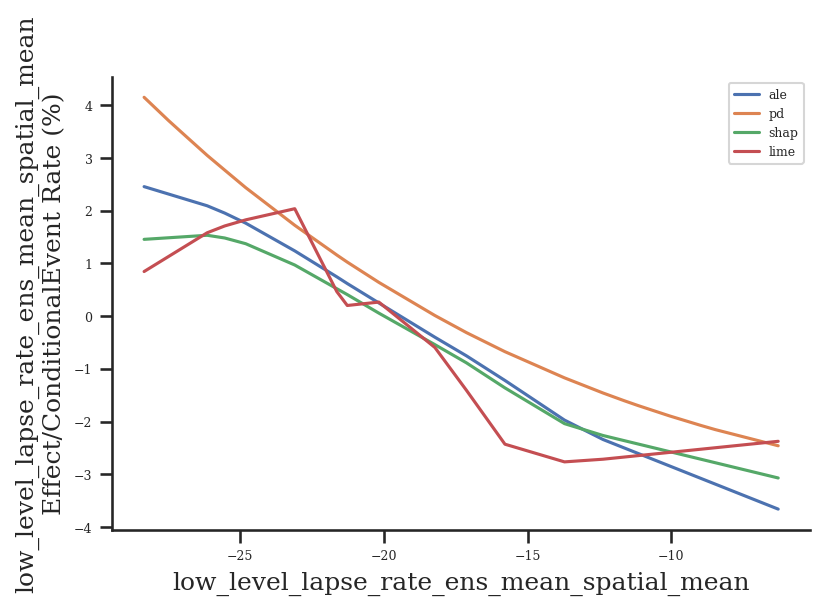

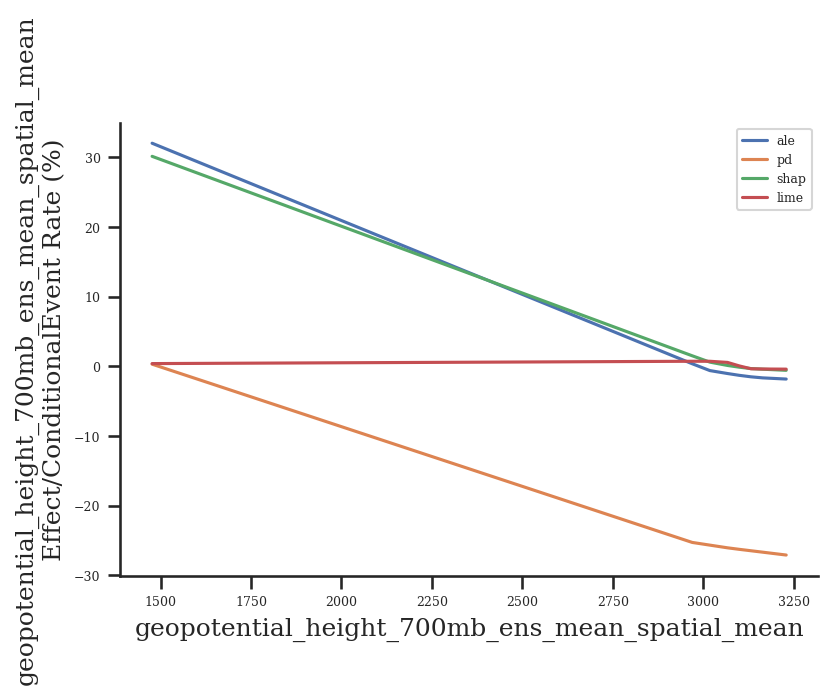

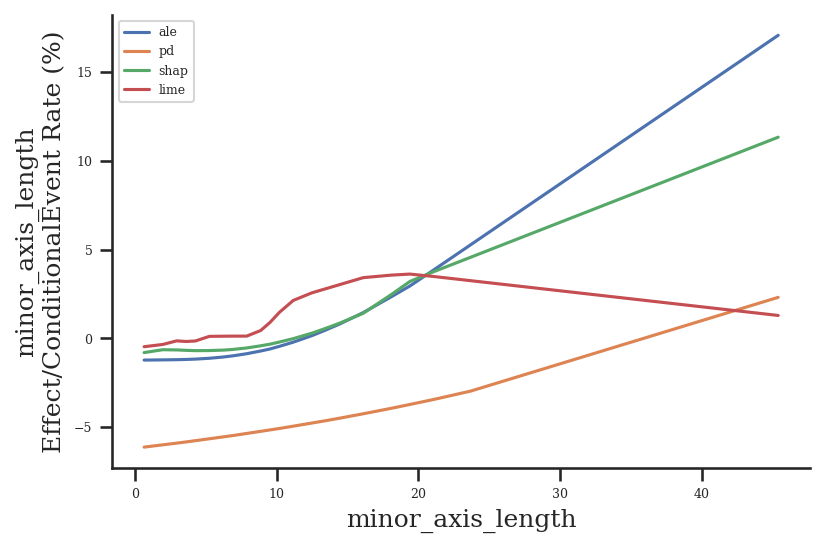

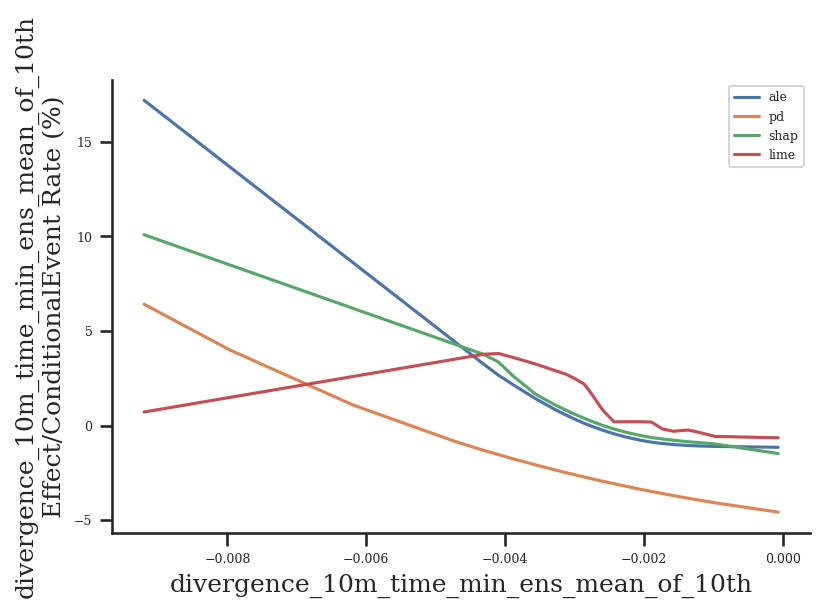

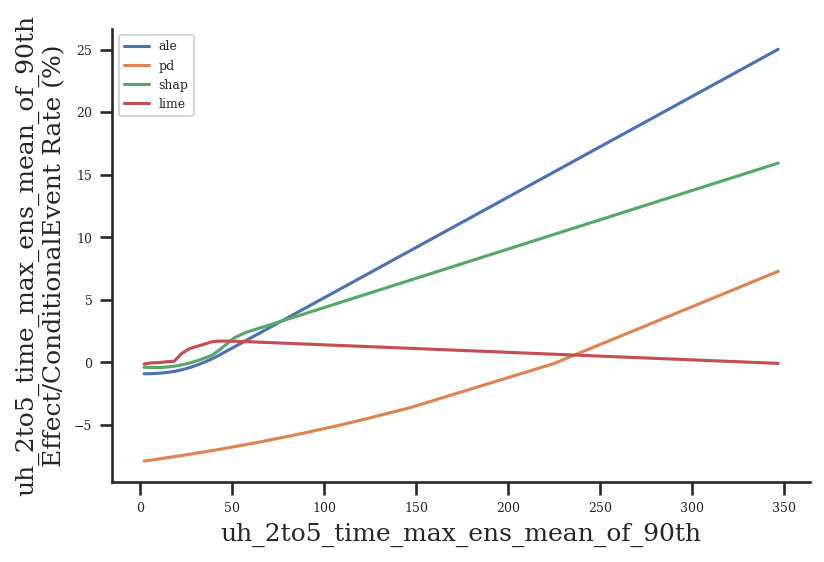

In [5]:
keys = ['ale',    'shap', 'pd', 'lime', 'ti']
columns = ['ALE', 'SHAP', 'PD', 'LIME', 'TI']

dfs = []
dfs_std = []
hazards = ['severe_hail']#['tornado', 'severe_hail', 'severe_wind', 'road_surface']

for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    ale, _, shap_vals, X_shap, pd_ds, lime_vals, X_lime, ti_vals, X_ti = load_explain(hazard,  return_pd=True)
    df, df_std = measure_corr(ale, shap_vals, pd_ds, lime_vals, X_lime, ti_vals, X_ti, 
                              features=top_features[hazard], plot=True)
    dfs.append(df)
    dfs_std.append(df_std)
    
df = pd.concat(dfs, axis=0)
df_std = pd.concat(dfs_std, axis=0)

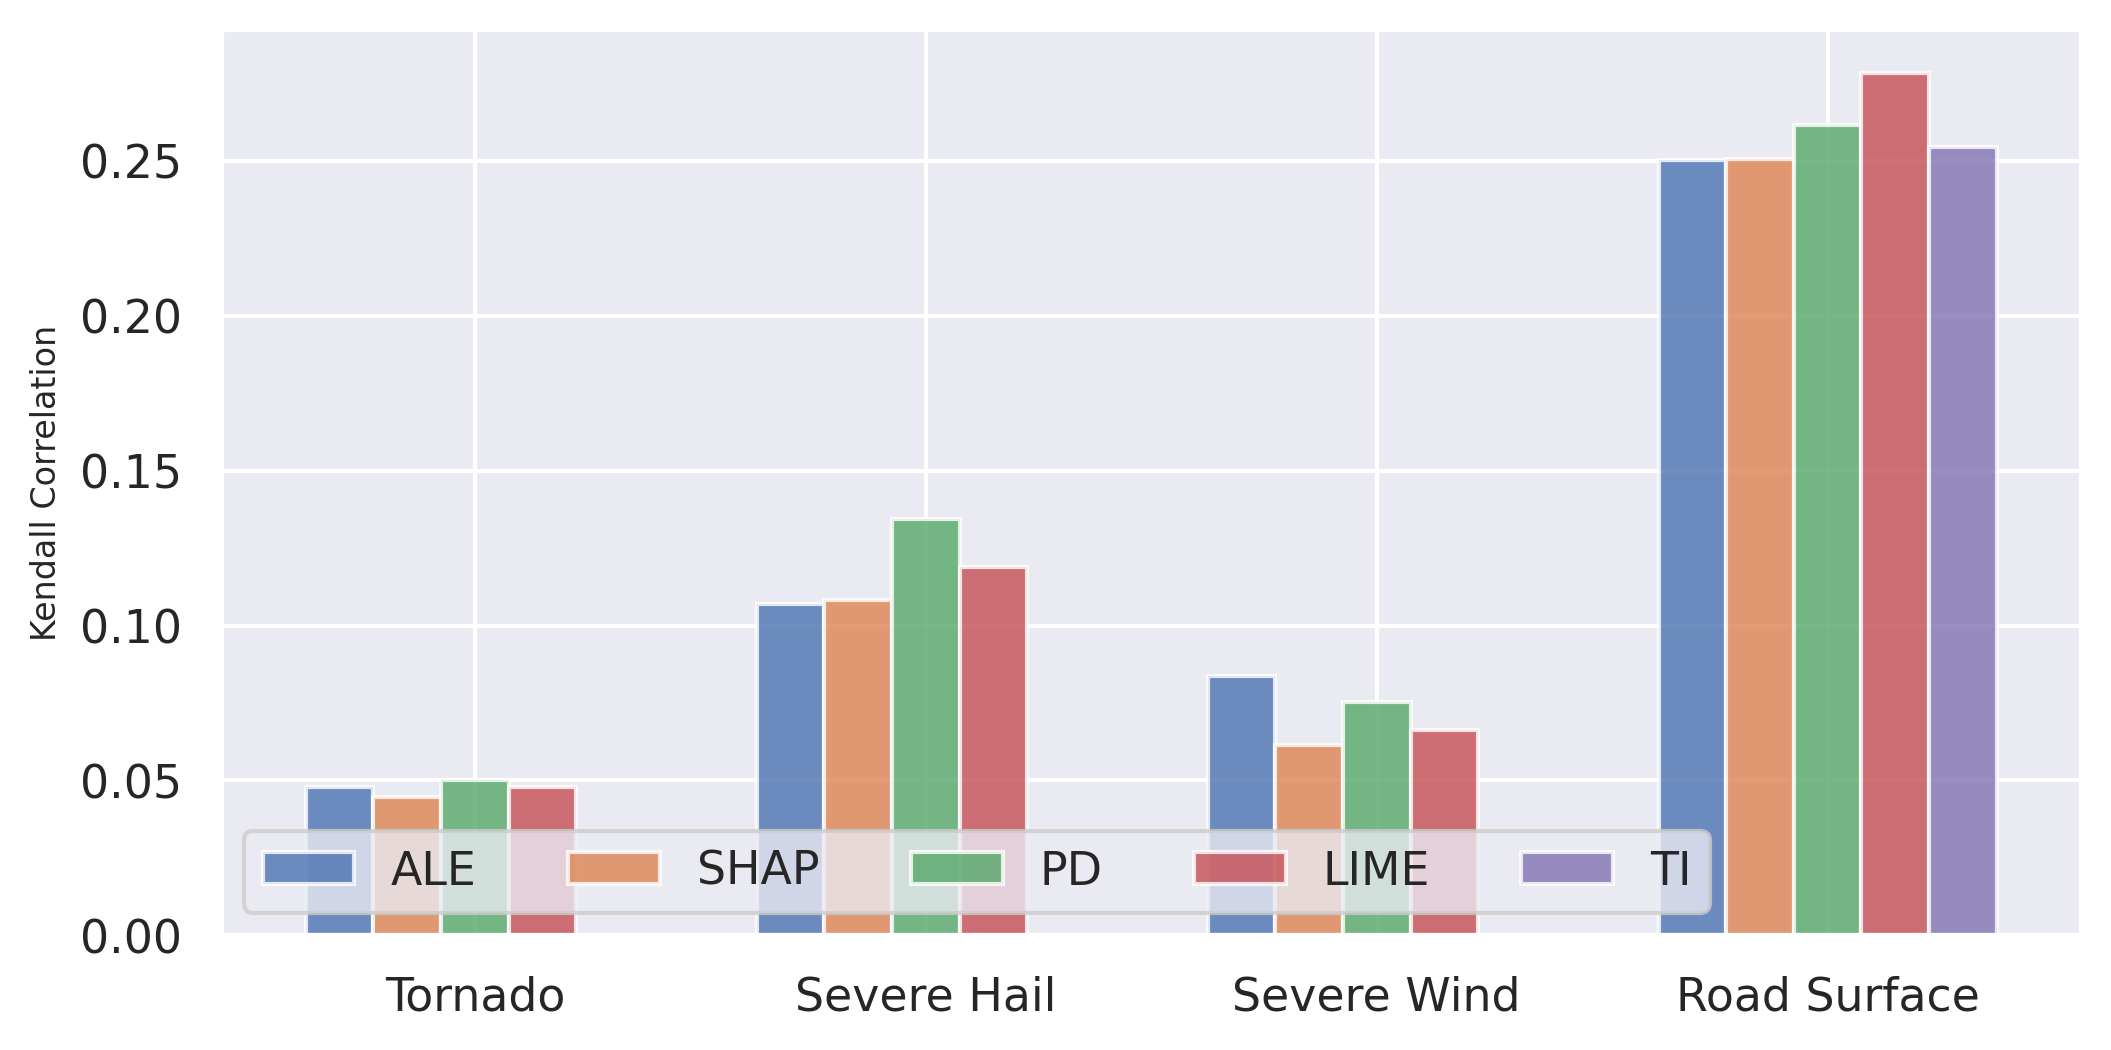

In [7]:
import seaborn as sns
sns.set_theme()

fig, ax = plt.subplots(dpi=300, figsize=(8,4))
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

pos = (x-(2*width), x-width, x, x+width, x+(2*width))

ax.bar(pos[0], df_std['ale'], alpha=0.8, 
       width=width, label='ALE',)# yerr=df_std['ale']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[1] , df_std['shap'], alpha=0.8,
       width=width, label='SHAP',)# yerr=df_std['shap']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[2], df_std['pd'], alpha=0.8,
       width=width, label='PD',)# yerr=df_std['pd']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[3], df_std['lime'], alpha=0.8,
       width=width, label='LIME',)# yerr=df_std['lime']/2, capsize=3, error_kw={'alpha':0.6})

ax.bar(pos[4], df_std['ti'], alpha=0.8,
       width=width, label='TI',)# yerr=df_std['ti']/2, capsize=3, error_kw={'alpha':0.6})

ax.set_ylabel('Kendall Correlation', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend(ncol=5, loc='lower left')

In [8]:
def set_legend(n_panels, fig, ax, major_ax, ncol = 3, bbox_to_anchor=(0.5, -0.35)):
        """
        Set a single legend on the bottom of a figure
        for a set of subplots.
        """
        handles, labels = ax.get_legend_handles_labels()

        # Shrink current axis's height by 10% on the bottom
        box = major_ax.get_position()
        major_ax.set_position(
            [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
        )

        # Put a legend below current axis
        major_ax.legend(
            handles,
            labels,
            loc="lower center",
            bbox_to_anchor=bbox_to_anchor,
            fancybox=True,
            shadow=True,
            ncol=ncol,
        )

In [9]:
df_std

,ale,pd,shap,lime,ti
0,0.047755,0.050114,0.044798,0.047959,NaN
0,0.107103,0.134225,0.108303,0.118782,NaN
0,0.083830,0.075171,0.061409,0.066410,NaN
0,0.250123,0.261389,0.250425,0.278459,0.254542


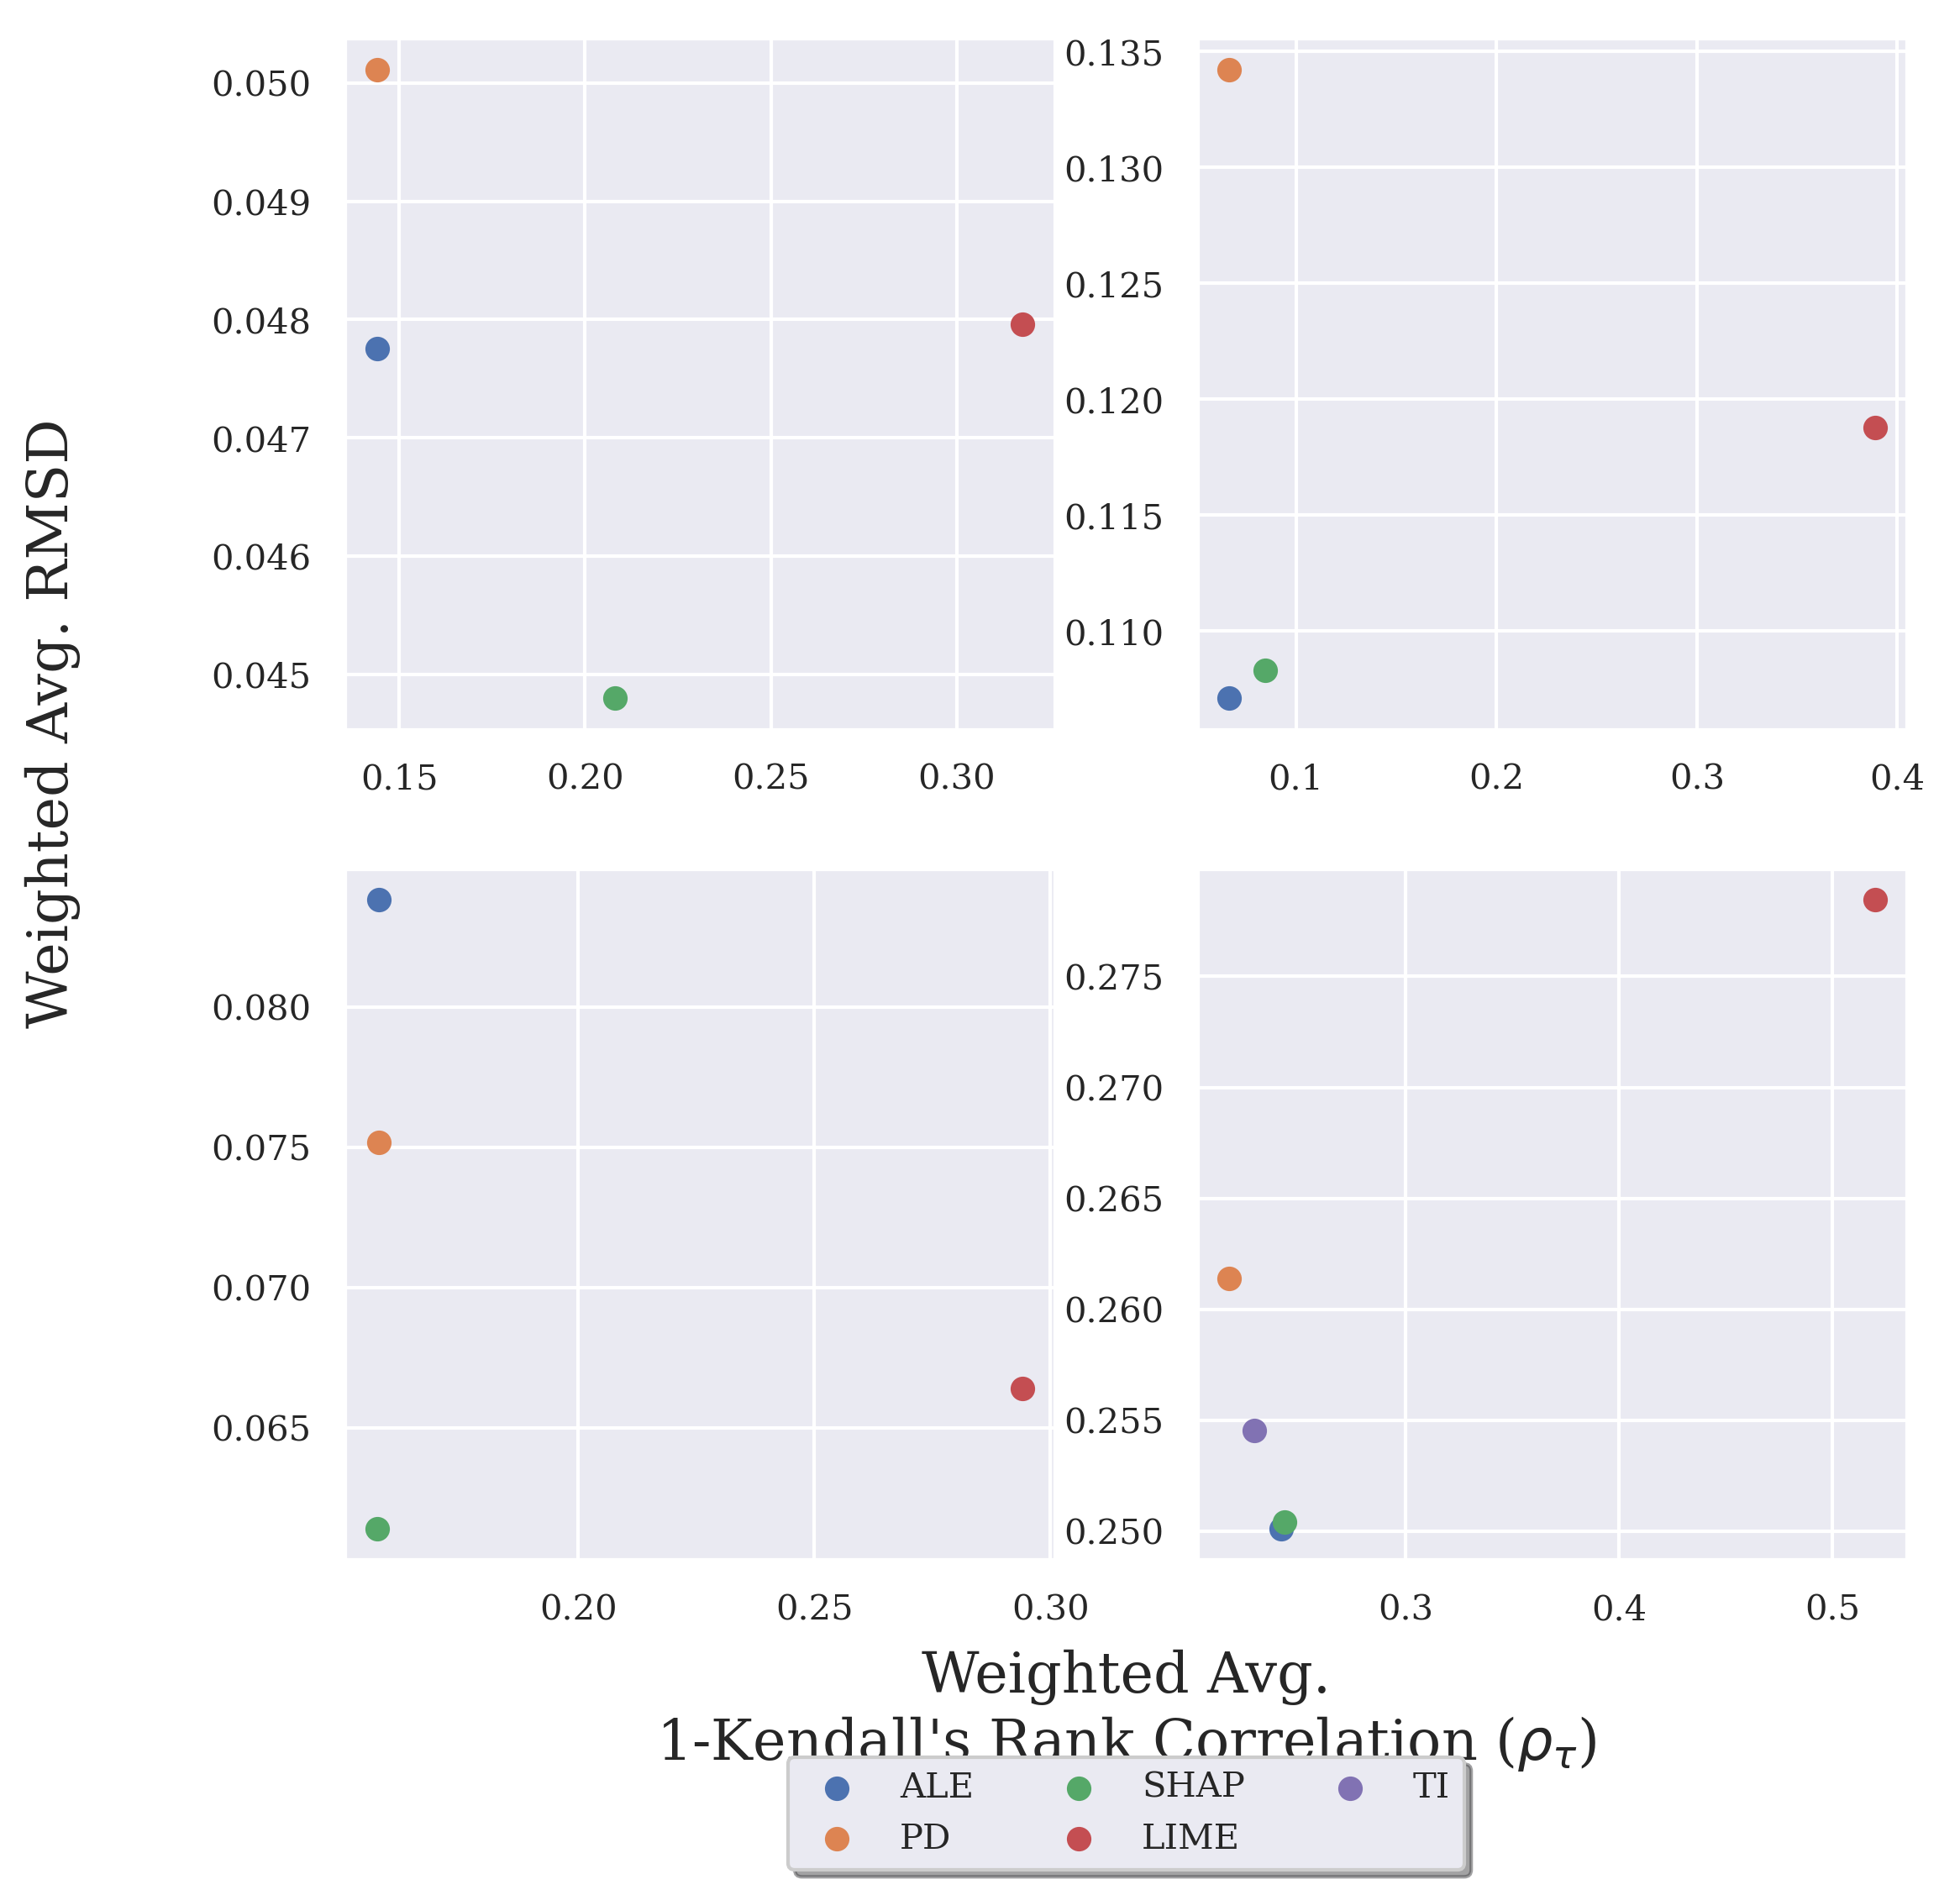

In [10]:
from skexplain.plot.base_plotting import PlotStructure
base_plt = PlotStructure(BASE_FONT_SIZE = 16, seaborn_kws={'style': 'darkgrid'})

fig, axes = base_plt.create_subplots(n_panels=4, n_columns=2, figsize=(8,8), dpi=300, 
                                      wspace=0.2, hspace=0.2, sharex=False, sharey=False)

hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']
labels = []

for i, (ax, hazard) in enumerate(zip(axes.flat, hazards)):
    xs,ys = df.iloc[i,:], df_std.iloc[i,:]
    inds = list(df.iloc[0,:].index)
    for x,y,label in zip(xs, ys, inds): 
        ax.scatter(1-x, y, label=label.upper())
        
major_ax = base_plt.set_major_axis_labels(fig, 
                           xlabel="Weighted Avg."+"\n"+r"1-Kendall's Rank Correlation ($\rho_{\tau}$)", 
                                              ylabel_left= r'Weighted Avg. RMSD',
                                              labelpad=50
                                             )
major_ax.grid(False)
set_legend(4, fig, ax, major_ax)